# DATA SCIENCE SCHOOL :: Introduction to ML in Python
### An Intensive Python ML Course
## Task Sheet: Regularized Multinomial Logistic Regression - Solutions

[&larr; Back to course webpage](http://datakolektiv.com/app_direct/introdsnontech/)

![](../img/IntroMLPython_Head.png)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SCHOOL :: Introduction to ML in Python course.

### Goran S. Milovanović, PhD
<b>DataKolektiv, Chief Scientist & Owner</b>

### Aleksandar Cvetković, PhD
<b>DataKolektiv, Consultant</b>

![](../img/DK_Logo_100.png)

## Setup

In [1]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# - visualization
import matplotlib.pyplot as plt
import seaborn as sns



# - parameters
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_theme()

# - rng
rng = np.random.default_rng()

# - plots
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=14)
sns.set_theme(style='white')

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

In [2]:
# - loading the dataset
# - UCI ML: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) (download winequality-red.csv)
# - place it in your _data/ directory
wine_data = pd.read_csv(os.path.join(data_dir, 'winequality-red.csv'), sep=';')
wine_data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


## Task 0

### Target: predict wine quality from all the predictors

In [3]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
predictors = wine_data.columns.drop('quality')
predictors

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [5]:
# - converting 'quality' variable which is numerical into ordered categorical
wine_data['quality'] = wine_data['quality'].astype(pd.CategoricalDtype(ordered=True))
wine_data['quality'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1599 entries, 0 to 1598
Series name: quality
Non-Null Count  Dtype   
--------------  -----   
1599 non-null   category
dtypes: category(1)
memory usage: 1.9 KB


In [6]:
wine_data['quality'].head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: category
Categories (6, int64): [3 < 4 < 5 < 6 < 7 < 8]

In [7]:
wine_data['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [9]:
### --- Preparing the variables 

# - feature matrix
X = wine_data.drop(columns='quality')
# - we append a constant column of ones to the feature matrix
X = sm.add_constant(X)

# - target vector
y = wine_data['quality']

In [10]:
# - fitting the MNR model to the data; we use the Newton's Conjugate Gradient method as the optimizer to compute the
#models coefficients
mnr_model = sm.MNLogit(exog=X, endog=y).fit(method='ncg', maxiter=100)
mnr_model.summary()

Optimization terminated successfully.
         Current function value: 0.913760
         Iterations: 46
         Function evaluations: 78
         Gradient evaluations: 78
         Hessian evaluations: 46


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                quality   No. Observations:                 1599
Model:                        MNLogit   Df Residuals:                     1539
Method:                           MLE   Df Model:                           55
Date:                Sun, 20 Nov 2022   Pseudo R-squ.:                  0.2287
Time:                        00:37:46   Log-Likelihood:                -1461.1
converged:                       True   LL-Null:                       -1894.2
Covariance Type:            nonrobust   LLR p-value:                2.987e-146
========================================================================================
           quality=4       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  150.7854    547.747      0.275      0.783    -922.780    1224.351
fixed acidity           -0.6119      0.688     -0.889      0.374      -1.961       0.737
volatile acidity        -4.8509      2.448     -1.981      0.048      -9.649      -0.052
citric acid             -2.3627      4.063     -0.581      0.561     -10.326       5.601
residual sugar           0.1666      0.312      0.533      0.594      -0.446       0.779
chlorides              -10.3956      7.560     -1.375      0.169     -25.212       4.421
free sulfur dioxide     -0.1601      0.091     -1.757      0.079      -0.339       0.018
total sulfur dioxide     0.0839      0.050      1.678      0.093      -0.014       0.182
density               -131.9670    557.824     -0.237      0.813   -1225.283     961.349
pH                      -7.1129      5.073     -1.402      0.161     -17.056       2.831
sulphates                1.1854      3.746      0.316      0.752      -6.156       8.527
alcohol                  1.5048      0.877      1.715      0.086      -0.215       3.225
----------------------------------------------------------------------------------------
           quality=5       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -104.0851    522.953     -0.199      0.842   -1129.054     920.884
fixed acidity           -0.9018      0.651     -1.386      0.166      -2.177       0.373
volatile acidity        -7.8053      2.408     -3.241      0.001     -12.525      -3.086
citric acid             -2.7974      3.904     -0.716      0.474     -10.450       4.855
residual sugar          -0.1348      0.298     -0.453      0.651      -0.719       0.449
chlorides              -12.8486      6.884     -1.867      0.062     -26.340       0.643
free sulfur dioxide     -0.1366      0.088     -1.545      0.122      -0.310       0.037
total sulfur dioxide     0.0994      0.049      2.011      0.044       0.003       0.196
density                143.4813    532.624      0.269      0.788    -900.442    1187.404
pH                     -10.8172      4.888     -2.213      0.027     -20.398      -1.237
sulphates                0.9416      3.538      0.266      0.790      -5.994       7.877
alcohol                  1.4625      0.852      1.717      0.086      -0.207       3.132
----------------------------------------------------------------------------------------
           quality=6       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -71.9561    524.270     -0.137      0.891   -1099.506     955.594
fixed acidity           -0.7707      0.651     -1.184      0.236      -2.046       0.505
volatile acidity       -10.4437      2.432     -4.294      0.000     -15.211      -5.676
citric acid             -4.0991      

In [11]:
# - confusion matrix for the model prdictions; ordering of rows/columns correspond to the oredering of the classes
conf_matrix = mnr_model.pred_table()
conf_matrix

array([[  2.,   0.,   7.,   1.,   0.,   0.],
       [  1.,   1.,  34.,  15.,   2.,   0.],
       [  2.,   0., 514., 159.,   6.,   0.],
       [  0.,   0., 207., 391.,  40.,   0.],
       [  0.,   0.,  13., 120.,  66.,   0.],
       [  0.,   0.,   0.,  10.,   8.,   0.]])

In [14]:
# - accuracy of the model
mnr_acc = np.sum(np.diag(conf_matrix))/np.sum(conf_matrix)
mnr_acc

0.6091307066916823

### Regularization of the model coefficients: Ridge (L2) Regularization

Now we are going to use scikit-learn to perform *Regularized* Multinomial Logistic Regression; we'll be using the Ridge Regression. 

The Ridge Regression model is obtained by minimizing the function

$$-C\cdot LL + \frac{1}{2}L_2^2,$$

where $LL$ is Log-Likelihood of the 'ordinary' MNR, and $L_2^2$ is the squared *Frobenius norm* of model parameters matrix $W$:

$$L_2^2 = ||W||_F^2 = \sum_{i=1}^k\sum_{j=1}^K(\beta_i^{(j)})^2;$$

$k$ is the number of predictors, $K$ number of categories of the targert variable, and $\beta_i^{(j)}$ are model parameters. $C$ is the *Regularization (hyper)parameter* and it the invers of penalization hyperparameter $\alpha$.

In [15]:
# - import scikit-learn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix

In [16]:
### --- Preparing the variables 

# - feature matrix
X = wine_data.drop(columns='quality').values

# - target variable
y = wine_data['quality']

In [17]:
### --- Fitting a Ridge MNR Regularized model on the given data, with the regularization parameter C = 250

# - NOTE: LogisticRegression from scikit-learn implements L2 regularization BY DEFAULT
# - so, you actually don't need to pass 'penalty' parameter in order to implement Ridge Regularization
# - if you want to perform MNR without any regularization with scikit-learn, you need to pass 'penalty=none' parameter

log_reg = LogisticRegression(solver='newton-cg', penalty='l2', C=250)
log_reg.fit(X, y)

LogisticRegression(C=250, solver='newton-cg')

In [18]:
# - intercept of the model; entries correspond to the orderdering of the categories in the target variable 
log_reg.intercept_

array([-21.92075208,   1.95548122,   8.43134916,   2.14612481,
         2.8028652 ,   6.58493168])

In [20]:
# - coefficents of the model; rows correspond to the ordering of the categories in the target variable;
# - columns correspond to the predictors
log_reg.coef_

array([[ 6.14803951e-01,  7.56763474e+00,  2.45865287e+00,
         1.14608834e-02,  1.40139205e+01,  1.04510711e-01,
        -6.66259221e-02,  3.69122587e-01,  8.72678197e+00,
        -2.72743545e+00, -1.87880504e+00],
       [-1.13518559e-01,  2.80313116e+00,  1.59509973e-01,
         1.14656962e-01,  5.27580878e+00, -5.30471209e-02,
         1.69277450e-02, -3.07275513e+00,  1.44599702e+00,
        -2.27686797e+00, -3.21108286e-01],
       [-1.08836596e-01, -2.44317524e-01, -5.78272970e-01,
        -7.99026847e-02,  3.61521325e+00, -3.29943230e-02,
         3.37384507e-02,  4.80080982e+00, -7.93598622e-01,
        -2.17469094e+00, -5.90818556e-01],
       [-1.57653049e-02, -2.89753100e+00, -1.86281805e+00,
        -4.66663039e-02,  9.91879988e-01, -1.13792937e-02,
         1.73276089e-02,  3.33634205e+00, -9.78561474e-01,
         1.27877313e-01,  2.27470082e-01],
       [ 3.77687787e-02, -5.39289727e+00, -1.43891422e+00,
         9.54358594e-02, -6.43978670e+00, -6.89353735e-03,
  

In [21]:
# - accuracy of Ridge Regularization
log_reg.score(X, y)

0.610381488430269

In [22]:
# - accuracy of statsmodel's MNR model without the regularization
mnr_acc

0.6091307066916823

In [23]:
### --- Varying the regularization parameter for the Ridge Regularized Model
n_Cs = 25
Cs = np.linspace(1e-2, 500, n_Cs)

l2_coefs = []
accuracies = []
frob_norms_matrix = []
for C in Cs:
    
    # - fitting a Ridge Regularization
    ridge = LogisticRegression(solver='newton-cg', C=C, max_iter=1000)
    ridge.fit(X, y)
    
    # - squared L2 norm of model coefficients vectors for each category
    l2_c = np.linalg.norm(ridge.coef_, ord=2, axis=0)**2
    
    # - accuracy of a fitted Regularized Model
    acc = ridge.score(X, y)
    
    # - squared Frobenius norm of model coefficient matrix
    frob = np.linalg.norm(ridge.coef_, ord=2)**2
    
    l2_coefs.append(l2_c)
    accuracies.append(acc)
    frob_norms_matrix.append(frob)

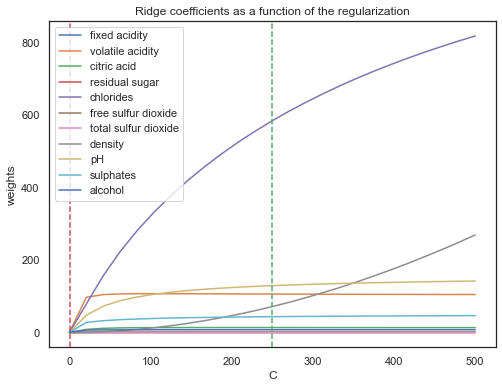

In [26]:
### --- Plotting the dependence of model parameters vs. the regularization hyperparameter
ax = plt.gca()

ax.plot(Cs, l2_coefs)
ax.axvline(x=1, c='r', ls='--') # red line, corresponding to C = 0
ax.axvline(x=250, c='g', ls='--') # green line, corresponding to C = 250
plt.xlabel("C")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(predictors)
plt.show()

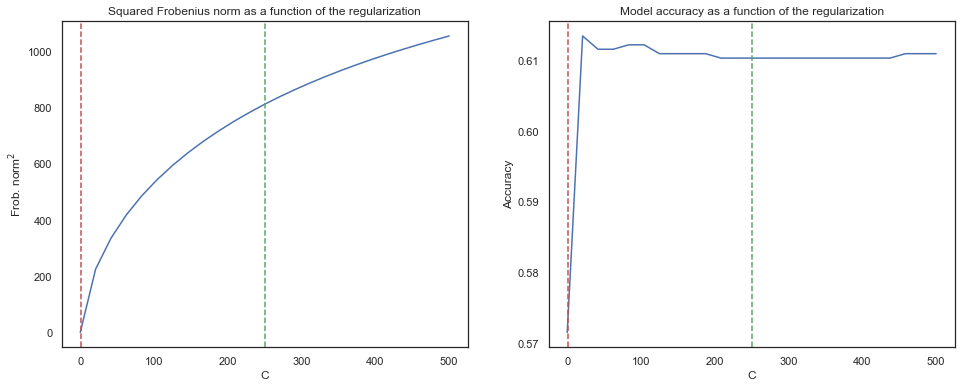

In [25]:
### --- Plotting the dependance of various model metrics vs. the regularization hyperparameter
ig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)


# - squared Frobenius vs. C
ax[0].plot(Cs, frob_norms_matrix)
ax[0].axvline(x=1, c='r', ls='--') # red line, corresponding to C = 1
ax[0].axvline(x=250, c='g', ls='--') # green line, corresponding to C = 250
ax[0].set_xlabel("C")
ax[0].set_ylabel("Frob. norm$^2$")
ax[0].set_title("Squared Frobenius norm as a function of the regularization")
ax[0].axis("tight")

# - accuracy vs. C
ax[1].plot(Cs, accuracies)
ax[1].axvline(x=1, c='r', ls='--') # red line
ax[1].axvline(x=250, c='g', ls='--') # green line
ax[1].set_xlabel("C")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model accuracy as a function of the regularization")
ax[1].axis("tight");

From the right graph above, we may assume that for regularization hyperparameter C ~ 12.5 we may obtain a good approximation of the best model.



In [27]:
### --- Fitting an assumed approximation of the best Ridge Regularized model
ridge_best = LogisticRegression(C=12.5, solver='newton-cg')
ridge_best.fit(X, y)

LogisticRegression(C=12.5, solver='newton-cg')

In [28]:
ridge_best.intercept_

array([-5.36870319, -0.40200138, 11.58437309,  3.49235553, -4.55844927,
       -4.74757479])

In [29]:
ridge_best.coef_

array([[ 3.45549775e-01,  6.58733940e+00,  1.36310056e+00,
         9.23288000e-02,  3.03620804e+00,  8.65226195e-02,
        -6.34795536e-02,  2.68289765e-02,  3.83621757e+00,
        -1.03498214e+00, -1.53389937e+00],
       [-1.28796833e-01,  2.91022314e+00,  4.25363277e-01,
         1.16383928e-01,  1.81702215e+00, -4.80549423e-02,
         1.45603721e-02, -1.43138264e-01,  1.44750820e+00,
        -1.93177259e+00, -3.85766308e-01],
       [-8.69221363e-02,  6.00823040e-02, -1.86469471e-01,
        -7.78867289e-02,  2.24085323e+00, -2.76364534e-02,
         3.12840393e-02,  2.63178557e-01, -2.91219185e-01,
        -2.28454575e+00, -6.66343573e-01],
       [ 1.11162390e-02, -2.53942397e+00, -1.44085328e+00,
        -4.64611861e-02,  2.20915151e-01, -6.14488130e-03,
         1.49491281e-02,  1.89260606e-01, -3.73775558e-01,
        -1.14570432e-01,  1.55758454e-01],
       [ 6.53378941e-02, -5.04475830e+00, -1.07785365e+00,
         8.43238762e-02, -4.14733996e+00, -2.33029029e-03,
  

In [30]:
# - accuracy of our model
ridge_best.score(X, y)

0.6128830519074422

We did manage to obtain even more accurate model! But is this the best we can?

### Cross-validation: The search for the best regularization hyperparameter

In [31]:
### --- Performing the cross-validation across 10 log-distributed values of C in the [10^(-4), 10^4] interval
ridgeCV = LogisticRegressionCV(Cs=10, solver='newton-cg', max_iter=1000)
ridgeCV.fit(X, y)

LogisticRegressionCV(max_iter=1000, solver='newton-cg')

In [32]:
# - regularization hyperparameters for the best model
# - note that we do not obtain a singe C, but a set of regularization hyperparameters
# - each entry corresponds to the best regularization value for a given category
ridgeCV.C_

array([21.5443469, 21.5443469, 21.5443469, 21.5443469, 21.5443469,
       21.5443469])

In [33]:
ridgeCV.intercept_

array([-8.70703436, -0.6268013 , 11.60633644,  3.69046602, -3.80397255,
       -2.15899426])

In [35]:
ridgeCV.coef_

array([[ 3.92136523e-01,  7.10622562e+00,  1.91394294e+00,
         7.46392207e-02,  4.57710990e+00,  9.24234412e-02,
        -6.52203648e-02,  4.34018924e-02,  4.93801348e+00,
        -1.22160998e+00, -1.66053591e+00],
       [-1.21534890e-01,  2.90788123e+00,  3.71505773e-01,
         1.15774455e-01,  2.51955341e+00, -4.94293304e-02,
         1.52333700e-02, -2.53675412e-01,  1.49553963e+00,
        -2.08825508e+00, -3.65376147e-01],
       [-8.72968281e-02, -3.02295076e-02, -3.16930577e-01,
        -7.78551242e-02,  2.44378230e+00, -2.92766472e-02,
         3.20699892e-02,  4.42747262e-01, -3.87376376e-01,
        -2.31298916e+00, -6.41490196e-01],
       [ 9.36081293e-03, -2.65791244e+00, -1.58917105e+00,
        -4.59737341e-02,  2.61416751e-01, -7.79036318e-03,
         1.57259097e-02,  3.17240946e-01, -5.00145962e-01,
        -1.02728491e-01,  1.80037670e-01],
       [ 6.19513711e-02, -5.19631840e+00, -1.23124123e+00,
         8.75564597e-02, -4.92405100e+00, -3.78764476e-03,
  

In [36]:
# - accuracy of the model obtained through the  cross-validation
ridgeCV.score(X, y)

0.6135084427767354

We have managed to obtained and even more accurate model through Ridge Regularization and cross-validation!

In [37]:
confusion_matrix(y, ridgeCV.predict(X))

array([[  1,   1,   7,   1,   0,   0],
       [  0,   1,  35,  16,   1,   0],
       [  2,   0, 517, 158,   4,   0],
       [  0,   0, 206, 397,  35,   0],
       [  0,   0,  13, 121,  65,   0],
       [  0,   0,   0,  10,   8,   0]], dtype=int64)

## Task 1

### LASSO (L1) Regularization

*LASSO* is another way to regularize MNR model. It's obtained by minimizing the function

$$-C\cdot LL + \frac{1}{2}L_1,$$

where $LL$ is Log-Likelihood of the 'ordinary' MNR, and $L_1$ is the $L_1$ norm of model parameters matrix $W$:

$$L_1 = ||W||_1 = \sum_{i=1}^k\sum_{j=1}^K|\beta_i^{(j)}|.$$

$C$ is, of course regularization hyperparameter.

Both Ridge and LASSO Regularizations are a part of a more general *Elastic-net* Regularization, obtaned by minimizing the function 

$$-C\cdot LL + \rho L_1 + \frac{1 - \rho}{2}L_2^2$$

where $\rho\in[0,1]$ is yet another hyperparameter. For $\rho = 0$ one recovers Ridge Regularization, and for $\rho = 1$ LASSO Regularization.

In [38]:
### --- Varying the penalization parameter for the LASSO Regularized Model
n_Cs = 25
Cs = np.linspace(1e-2, 500, n_Cs)

l1_coefs = []
accuracies = []
l1_norms_matrix = []
for C in Cs:
    # - fitting a LASSO Regularization
    ridge = LogisticRegression(solver='liblinear', penalty='l1', C=C, max_iter=1000)
    ridge.fit(X, y)
    
    # - L1 norm of model coefficients vectors for each category
    l1_c = np.linalg.norm(ridge.coef_, ord=1, axis=0)
    
    # - accuracy of a fitted Regularized Model
    acc = ridge.score(X, y)
    
    # - L1 norm of model coefficient matrix
    l1_m = np.linalg.norm(ridge.coef_, ord=1)
    
    l1_coefs.append(l1_c)
    accuracies.append(acc)
    l1_norms_matrix.append(l1_m)

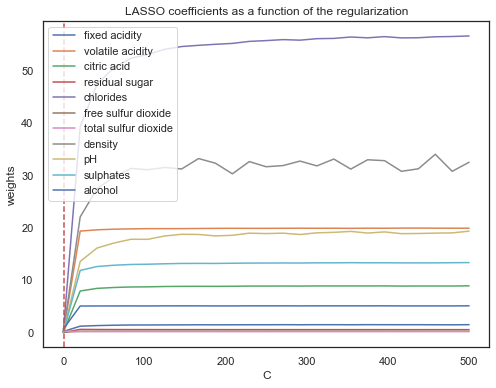

In [39]:
### --- Plotting the dependence of model parameters vs. the regularization hyperparameter
ax = plt.gca()

ax.plot(Cs, l1_coefs)
ax.axvline(x=1, c='r', ls='--') # red line, corresponding to C = 1
plt.xlabel("C")
plt.ylabel("weights")
plt.title("LASSO coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(predictors)
plt.show()

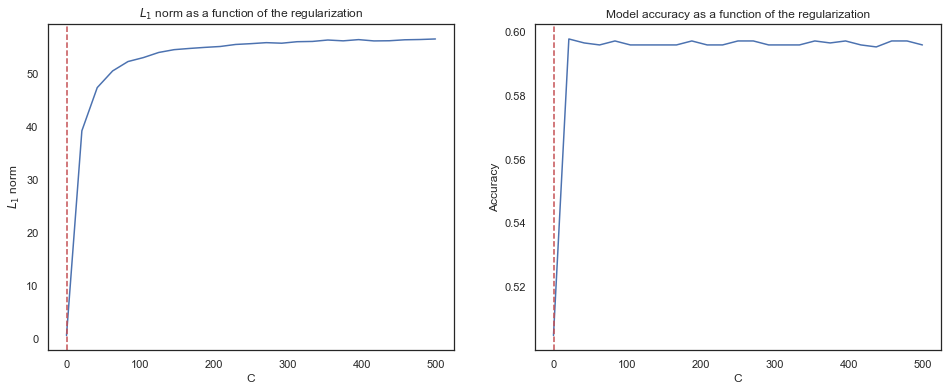

In [40]:
### --- Plotting the dependance of various model metrics vs. the regularization hyperparameter
ig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)


# - L1-norm vs. C
ax[0].plot(Cs, l1_norms_matrix)
ax[0].axvline(x=1, c='r', ls='--') # red line
ax[0].set_xlabel("C")
ax[0].set_ylabel("$L_1$ norm")
ax[0].set_title("$L_1$ norm as a function of the regularization")
ax[0].axis("tight")

# - Model accuracy vs. C
ax[1].plot(Cs, accuracies)
ax[1].axvline(x=1, c='r', ls='--') # red line
ax[1].set_xlabel("C")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model accuracy as a function of the regularization")
ax[1].axis("tight");

In [41]:
# - fitting an assumed best approximation for C = 12.5
lasso_best = LogisticRegression(C=12.5, solver='liblinear', penalty='l1')
lasso_best.fit(X, y)

LogisticRegression(C=12.5, penalty='l1', solver='liblinear')

In [42]:
lasso_best.intercept_

array([-6.55180207, -2.88883366,  4.32526247, -1.64351779, -3.47850571,
        0.        ])

In [43]:
lasso_best.coef_

array([[ 3.65817818e-01,  7.90273263e+00,  2.08109113e+00,
         8.57437737e-02,  6.59875115e+00,  1.24895669e-01,
        -9.27332666e-02, -3.04471322e+00,  3.81915533e+00,
        -2.94462641e-01, -1.62552021e+00],
       [-1.42110614e-01,  3.72258059e+00,  7.93424523e-01,
         1.74363533e-01,  9.45097376e-01, -2.60742348e-02,
        -1.04352303e-02, -2.68439658e+00,  1.35173036e+00,
        -9.21484664e-01, -2.65444221e-01],
       [-7.74349772e-02,  1.72295246e+00,  5.99198708e-01,
        -6.28049559e-02,  2.95669774e+00, -1.95749296e-02,
         1.86240702e-02,  4.66932292e+00,  9.14533891e-02,
        -2.38186534e+00, -8.86057172e-01],
       [ 7.16488868e-02, -1.70490889e+00, -1.30881513e+00,
        -2.12503899e-02, -1.40512482e-01,  2.30174891e-02,
        -1.22434064e-02, -1.26149262e+00,  1.93502866e-01,
         8.75446853e-01,  2.07804329e-01],
       [ 6.88340978e-02, -3.45256013e+00, -6.47023635e-02,
         1.39022662e-01, -7.44742495e+00,  1.29932492e-02,
  

In [44]:
lasso_best.score(X, y)

0.5966228893058161

In [45]:
mnr_acc

0.6091307066916823

### Cross-validation

In [46]:
### --- Performing the cross-validation across 10 log-distributed values of C in the [10^(-4), 10^4] interval
lassoCV = LogisticRegressionCV(Cs=10, solver='liblinear', penalty='l1', max_iter=1000)
lassoCV.fit(X, y)

LogisticRegressionCV(max_iter=1000, penalty='l1', solver='liblinear')

In [47]:
# - regularization values obtained through the cross-validation
lassoCV.C_

array([1.00000000e-04, 1.00000000e-04, 1.66810054e+02, 5.99484250e-03,
       2.78255940e+00, 1.00000000e-04])

In [48]:
lassoCV.intercept_

array([ 0.        ,  0.        ,  4.35742754,  0.        , -3.95619528,
        0.        ])

In [49]:
lassoCV.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.03346214,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.02913743,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.08057271,  1.73037389,  0.62438041, -0.06346217,  3.07401246,
        -0.01949724,  0.01857811,  4.74053656,  0.0766486 , -2.41664763,
        -0.88839255],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01890807, -0.01497895,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.04190089, -3.4422172 ,  0.        ,  0.12957047, -5.38751678,
         0.012998  , -0.01622839, -3.76252406, -1.07917075,  2.79336496,
         0.84791665],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.03247529,  0.        ,  0.        ,  0.        ,
         0.   

In [50]:
# - accuracy of the model obtained through the cross-validation
lassoCV.score(X, y)

0.6053783614759225

In [51]:
# - confustion matrix of the model obtained through cross-validation
confusion_matrix(y, lassoCV.predict(X))

array([[  0,   0,   8,   2,   0,   0],
       [  0,   0,  28,  25,   0,   0],
       [  0,   0, 522, 154,   5,   0],
       [  0,   0, 212, 385,  41,   0],
       [  0,   0,  15, 123,  61,   0],
       [  0,   0,   0,  10,   8,   0]], dtype=int64)

Goran S. Milovanović & Aleksandar Cvetković

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: <a href="https://www.gnu.org/licenses/gpl-3.0.txt">GPLv3</a> This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see <a href="http://www.gnu.org/licenses/">http://www.gnu.org/licenses/</a>.</font>